In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from ML_With_Pytorch_Scikit_learn_Sebastian.ch04.search_algorithms import SBS
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    LabelEncoder,
    StandardScaler,
)
from sklearn.datasets import load_wine
import pandas as pd
from sklearn.impute import SimpleImputer
from io import StringIO
import numpy as np


csv_data = """A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,"""

df = pd.read_csv(StringIO(csv_data))
df
# Will return numpy arrays
df.values

# Counting missing values
df.isnull().sum()

# One way is to remove null values
df.dropna(axis=0)  # -> row

#                    ^
df.dropna(axis=1)  # | columns
# Only drop rows where all columns are Nan
df.dropna(how="all")
# drop rows that have fewer than 4 real values
df.dropna(thresh=4)

# only drop rows where nan appears in specific columns
df.dropna(subset=["C"])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [2]:
# Simple Imputer
imr = SimpleImputer(missing_values=np.nan, strategy="mean")
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

# One other simpler way is to
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [3]:
# Identifying ordinal and nominal features

df = pd.DataFrame(
    [
        ["green", "M", 10.1, "class2"],
        ["red", "L", 13.5, "class1"],
        ["blue", "XL", 15.3, "class2"],
    ]
)
df.columns = ["color", "size", "price", "classlabel"]
df.head()
size_mapping = {"XL": 3, "L": 2, "M": 1}
df["size"] = df["size"].map(size_mapping)

# Remapping back
inv_mapping = {v: k for k, v in size_mapping.items()}
df["size"].map(inv_mapping)

# Transforming classlabels from string to integers
_ = list(np.unique(df["classlabel"]))
class_mapping = {label: idx for idx, label in enumerate(_)}
df["classlabel"] = df["classlabel"].map(class_mapping)
df.head()

inv_class_mapping = {v: k for k, v in class_mapping.items()}
df["classlabel"] = df["classlabel"].map(inv_class_mapping)
df.head()

# Alternative solution of class mapping with scikit-learn
class_le = LabelEncoder()
y = class_le.fit_transform(df["classlabel"].values)
print(y)
class_le.inverse_transform(y)

[1 0 1]


array(['class2', 'class1', 'class2'], dtype=object)

In [4]:
X = df[["color", "size", "price"]].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

# To apply transformation selectively in multiple columns can be done like this
c_transf = ColumnTransformer(
    [
        # here the first column applies the one hot encoder and the second and third column left untouched for sake of example
        ("onehot", OneHotEncoder(), [0]),
        (
            "nothing",
            "passthrough",
            [1, 2],
        ),
    ]
)
c_transf.fit_transform(X).astype(float)

# Alternative and easiest way of applying one hot encoder is to use panda
# Get dummies only convert string columns and leave numerical untouched
pd.get_dummies(df[["price", "color", "size"]])

# however one hot encoding can introduce multi collinearity in order to fix it we can drop a column
pd.get_dummies(df[["price", "color", "size"]], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,True,False
1,13.5,2,False,True
2,15.3,3,False,False


In [5]:
df = pd.DataFrame(
    [
        ["green", "M", 10.1, "class2"],
        ["red", "L", 13.5, "class1"],
        ["blue", "XL", 15.3, "class2"],
    ]
)
df.columns = ["color", "size", "price", "classlabel"]

df["x > M"] = df["size"].apply(lambda x: 1 if x in {"L", "XL"} else 0)
df["x > L"] = df["size"].apply(lambda x: 1 if x in {"XL"} else 0)

del df["size"]
df.head()

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


In [6]:
df_wine = load_wine(as_frame=True)
df_wine.frame
df_wine = pd.DataFrame(df_wine.frame)
df_wine.head()
print(np.unique(df_wine["target"]))

[0 1 2]


In [7]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Once you did fit_transform on the train data, no need to apply the fit again on the test subset; transform function would be enough
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
stdc = StandardScaler()
X_train_std = stdc.fit_transform(X_train)
X_test_std = stdc.transform(X_test)

In [8]:
X_train_std_viz = stdc.fit_transform(X_train).reshape(X_train_std.shape[0], -1)
df_xtrain_std = pd.DataFrame(X_train_std_viz)
print(df_xtrain_std.head())

df_ytrain = pd.DataFrame(y_train)
print(len(df_ytrain.columns))
print(len(df_xtrain_std.columns))
print("Data Types:")
print(df_xtrain_std.dtypes)
print(df_ytrain.dtypes)

print("\nMissing Values:")
print(df_xtrain_std.isnull().sum())
print(df_ytrain.isnull().sum())

         0         1         2         3         4         5         6   \
0  0.712259  2.220487 -0.130259  0.059629 -0.504327 -0.528316 -1.240000   
1  0.882292 -0.704572  1.175336 -0.090655  2.341479  1.016759  0.662995   
2  0.845856 -0.730230  1.175336  0.811048  0.135979  1.098079  1.163267   
3  0.578661 -0.473646  0.988823 -0.240939  0.776285  0.040922  0.457000   
4 -0.526554  0.090839 -0.689799 -0.391223 -0.362037 -1.146346 -1.377330   

         7         8         9         10        11        12  
0  0.841180 -1.052151 -0.292189 -0.200170 -0.821641 -0.629464  
1  1.088743 -0.492935  0.131521  1.339826  0.549313  1.475688  
2 -0.644195  1.252496  0.258634  1.068062  0.130811  1.629349  
3 -0.644195 -0.170963 -0.376931  0.660416  0.361708  1.045438  
4  2.161513 -1.187719  0.851827 -1.015462 -1.499903 -0.183848  
1
13
Data Types:
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    fl

In [9]:
lr = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", multi_class="ovr")
lr.fit(X_train_std, y_train)
print("Training accuracy:", lr.score(X_train_std, y_train))
print("Test accuracy:", lr.score(X_test_std, y_test))

# intercept_ corresponds to the bias unit and coef_ corresponds to the values $w_j$
lr.intercept_
lr.coef_

Training accuracy: 1.0
Test accuracy: 1.0


/home/itz-amethyst/venvs/global-venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


array([[ 1.24638855,  0.18002661,  0.74698396, -1.16413097,  0.        ,
         0.        ,  1.15838764,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55821643,  2.5086613 ],
       [-1.53905692, -0.38549152, -0.99601518,  0.36411622, -0.05918441,
         0.        ,  0.6664789 ,  0.        ,  0.        , -1.93172691,
         1.23917372,  0.        , -2.23251056],
       [ 0.13580665,  0.16857344,  0.35722031,  0.        ,  0.        ,
         0.        , -2.43831462,  0.        ,  0.        ,  1.56355796,
        -0.81894667, -0.49255481,  0.        ]])

**Types of weight coefficients:**

There are two primary types of weight coefficients:

1.  **Positive weight**: A positive weight indicates that a feature contributes to the desired output. In other words, an increase in this feature results in an increase in the predicted output.
2.  **Negative weight**: A negative weight indicates that a feature actually works against the desired output. An increase in this feature will result in a decrease in the predicted output.

**Interpretation of weight coefficients:**

Weight coefficients can be interpreted as follows:

*   **High positive weights**: A high positive weight on a feature indicates that it is strongly associated with the desired output and should be given more importance during model training.
*   **Low positive weights**: A low positive weight on a feature suggests that its relationship with the desired output is weaker, and it may not contribute significantly to the overall outcome.
*   **High negative weights**: A high negative weight on a feature indicates that it has an adverse effect on the desired output. Avoiding or minimizing this feature might help improve model performance.
*   **Low negative weights**: A low negative weight suggests that the relationship between the feature and the desired output is weak, and it may not be necessary to consider this feature during model training.

**How are weight coefficients calculated?**

Weight coefficients can be calculated using various methods, including:

1.  **Gradient Descent**: In linear regression, for example, weight coefficients are updated based on the gradient of the cost function with respect to each parameter.
2.  **Regularization techniques**: Regularization methods like Lasso (L1 regularization) and Ridge (L2 regularization) can help determine optimal weights by minimizing the complexity of the model while ensuring good
generalization performance.

**Importance of weight coefficients:**

Weight coefficients are essential for understanding how individual features contribute to the overall output. By analyzing these coefficients, you can:

*   **Identify feature importance**: Determine which features have the most significant impact on the desired outcome.
*   **Optimize model performance**: Adjust or remove unimportant features to improve model accuracy and generalization.
*   **Regularize models**: Use regularization techniques to prevent overfitting by reducing the influence of less important features.

/home/itz-amethyst/venvs/global-venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/itz-amethyst/venvs/global-venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/itz-amethyst/venvs/global-venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/itz-amethyst/venvs/global-venv/lib

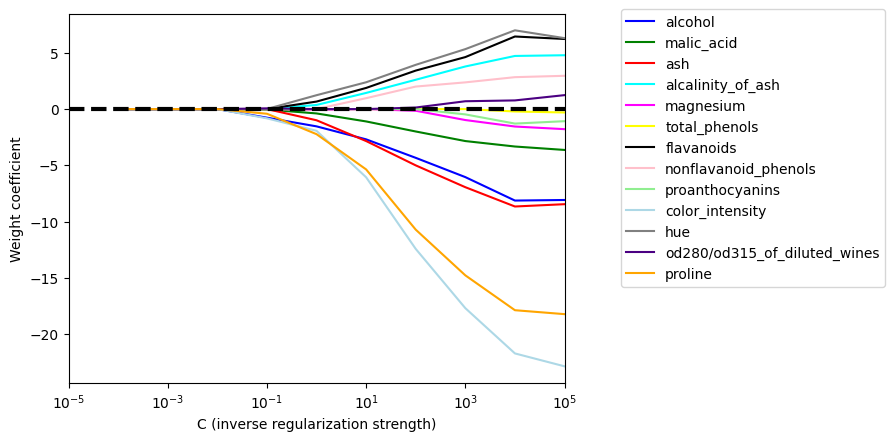

In [10]:
fig = plt.figure()
ax = plt.subplot(111)
colors = [
    "blue",
    "green",
    "red",
    "cyan",
    "magenta",
    "yellow",
    "black",
    "pink",
    "lightgreen",
    "lightblue",
    "gray",
    "indigo",
    "orange",
]
weights, params = [], []
for c in np.arange(-4.0, 6.0):
    lr = LogisticRegression(
        penalty="l1", C=10.0**c, solver="liblinear", multi_class="ovr", random_state=0
    )
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
df_wine_without_target = df_wine.drop("target", axis=1)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(
        params,
        weights[:, column],
        label=df_wine_without_target.columns[column],
        color=color,
    )
plt.axhline(0, color="black", linestyle="--", linewidth=3)
plt.xlim([10 ** (-5), 10**5])
plt.ylabel("Weight coefficient")
plt.xlabel("C (inverse regularization strength)")
plt.xscale("log")
plt.legend(loc="upper left")
ax.legend(loc="upper center", bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

[2 0 0 0 2 1 1 2 1 1 1 0 1 2 0 2 1 0 2 2 1 0 1 1 1 1 2 0 1 1 0 0 2 0 1 0 0
 1 2 2 0 2 2 2 0 1 2 2 1 2 1 1 1 0 1 1 2 2 1 0 0 1 2 2 1 0 1 1 1 0 0 0 0 0
 2 0 1 2 1 1 2 0 1 0 1 1 2 1 0 0 0 2 1 0 0 1 1 2 2 1 0 0 1 1 2 0 2 0 1 1 1
 1 0 2 0 0 0 0 1 1 2 2 1 1]


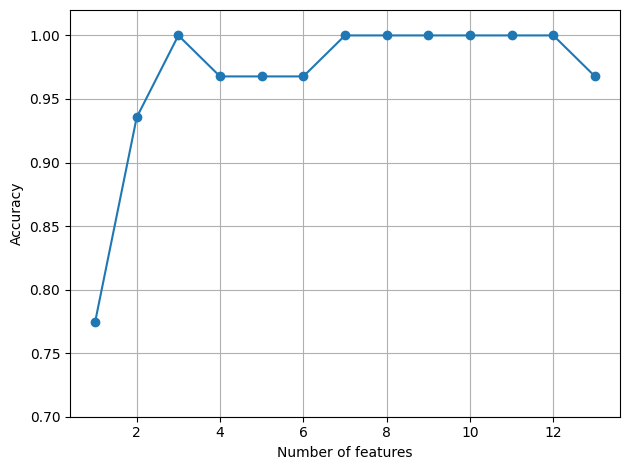

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
print(y_train)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker="o")
plt.ylim([0.7, 1.02])
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
# To get the important features on the 11eth subset which has 3 features and gained acc1.0


k3 = list(sbs.subsets_[10])
print(df_wine.columns[0:][k3])
# Accuracy of using all features
knn.fit(X_train_std, y_train)
print("Training accuracy: ", knn.score(X_train_std, y_train))
print("Training accuracy: ", knn.score(X_test_std, y_test))
# Accuracy of using only 3 selected features
knn.fit(X_train_std[:, k3], y_train)
print("Training accuracy: ", knn.score(X_train_std[:, k3], y_train))
print("Training accuracy: ", knn.score(X_test_std[:, k3], y_test))
# Although we used only 3 features out of 13 features in total from dataset and we do not observe much drop in accuracies

Index(['alcohol', 'malic_acid', 'od280/od315_of_diluted_wines'], dtype='object')
Training accuracy:  0.967741935483871
Training accuracy:  0.9629629629629629
Training accuracy:  0.9516129032258065
Training accuracy:  0.9259259259259259


# Assessing feature importance with Random Forests

 1) proline                        0.185453
 2) flavanoids                     0.174751
 3) color_intensity                0.143920
 4) od280/od315_of_diluted_wines   0.136162
 5) alcohol                        0.118529
 6) hue                            0.058739
 7) total_phenols                  0.050872
 8) magnesium                      0.031357
 9) malic_acid                     0.025648
10) proanthocyanins                0.025570
11) alcalinity_of_ash              0.022366
12) nonflavanoid_phenols           0.013354
13) ash                            0.013279


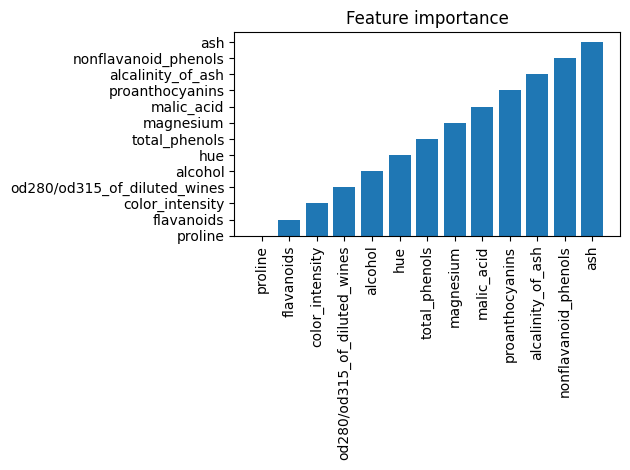

In [13]:
feat_labels = df_wine.columns[:-1]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title("Feature importance")
plt.bar(range(X_train.shape[1]), feat_labels[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show();



In [14]:
# Alternative way with scikit-learn
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print("Number of fetures that meet this threshold criterion: ", X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Number of fetures that meet this threshold criterion:  5
 1) proline                        0.185453
 2) flavanoids                     0.174751
 3) color_intensity                0.143920
 4) od280/od315_of_diluted_wines   0.136162
 5) alcohol                        0.118529
